[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): None
[WARNING] When reaching max steps, both 'terminate' and 'truncate will be True.Generally, only the `truncate` should be `True`. (base_env.py:390)
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


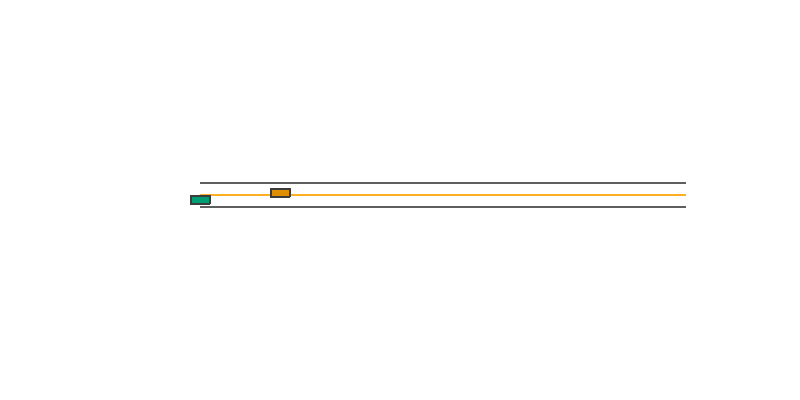

In [7]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.component.vehicle.vehicle_type import DefaultVehicle
from metadrive.utils import generate_gif
from metadrive.policy.idm_policy import IDMPolicy, TrajectoryIDMPolicy
from metadrive.policy.expert_policy import ExpertPolicy
from metadrive.utils.draw_top_down_map import draw_top_down_map
import matplotlib.pyplot as plt
from metadrive.component.lane.straight_lane import StraightLane
from metadrive.scenario.parse_object_state import parse_object_state, get_idm_route, get_max_valid_indicis

scenario_config = {'map_config': {'type': 'block_sequence', 
                                  'config': 'S', 
                                  'lane_width': 3, 
                                  'lane_num': 1, 
                                  'start_position': [0, 0],
                                 },
                   'traffic_density':0,
                   'vehicle_config':{
                                    'spawn_position_heading': [[0,0],0],
                   },
                   'use_render': True,
                   "truncate_as_terminate":True,
                   "crash_vehicle_done": True,
                  }

env=MetaDriveEnv(scenario_config)
frames = []


ego_traj = get_idm_route([[5, 1.5], [20, 1.5]])
npc_traj = get_idm_route([[20, 2],[20, 2],[20, 2],[20, 2]])

# ego_traj = get_idm_route([[0, 0], [10, 0], [40, 0]])
# npc_traj = get_idm_route([[40, 0], [10, 0],[0, 0]])

try:
    env.reset()
    cfg=env.config["vehicle_config"]
    cfg["navigation"]=None # it doesn't need navigation system
    
    npc = env.engine.spawn_object(DefaultVehicle, 
                                vehicle_config=cfg, 
                                position=[20,2], 
                                heading=0)

    # npc = env.engine.spawn_object(DefaultVehicle, 
    #                             vehicle_config=cfg, 
    #                             position=[40,0], 
    #                             heading=3.14)
    
    env.engine.add_policy(npc.id, TrajectoryIDMPolicy, npc, env.engine.generate_seed(), ego_traj)
    env.engine.add_policy(env.agent.id, TrajectoryIDMPolicy, env.agent, env.engine.generate_seed(), ego_traj)
    
    for _ in range(100):
        # npc.before_step([0, 0])
        # p = env.engine.get_policy(npc.name)
        # npc.before_step(p.act(True))
        # _,r,_,_,info = env.step([0,0])
        env.step([0,0])
        frame=env.render(mode="topdown", 
                         window=False,
                         screen_size=(800, 400),
                         draw_target_vehicle_trajectory=True,
                         scaling=4,
                         camera_position=(50,0))
        frames.append(frame)

        if info['crash']:
            break
    generate_gif(frames, gif_name="102804.gif")
finally:
    env.close()

from IPython.display import Image
Image(open("102804.gif", "rb").read())